In [28]:
# Initialization and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For modeling
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,
                           precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# For statistical tests
from scipy import stats

## 1. Initial Data Understanding and Preprocessing
I began by thoroughly examining the restaurant inspection dataset to understand its structure
and potential challenges. The dataset contains various features about restaurant inspections,
including location data, inspection scores, and violation information.


Initial Data Exploration
Initial shape: (262638, 27)

Column types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262638 entries, 0 to 262637
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   CAMIS                  262638 non-null  object
 1   DBA                    262638 non-null  object
 2   BORO                   262638 non-null  object
 3   BUILDING               262263 non-null  object
 4   STREET                 262635 non-null  object
 5   ZIPCODE                259954 non-null  object
 6   PHONE                  262636 non-null  object
 7   CUISINE DESCRIPTION    259322 non-null  object
 8   INSPECTION DATE        262638 non-null  object
 9   ACTION                 259322 non-null  object
 10  VIOLATION CODE         257693 non-null  object
 11  VIOLATION DESCRIPTION  257693 non-null  object
 12  CRITICAL FLAG          262638 non-null  object
 13  SCORE                  249243 non-nu

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1
count,262638,262638,262638,262263,262635,259954,262636,259322,262638,259322,...,259322,262279,262279,259313,259328,259328,257975,261994,259313,0
unique,29760,23881,6,7677,2450,231,26536,89,1780,5,...,33,24048,24048,69,51,1178,20766,20434,194,0
top,40365904,DUNKIN,Manhattan,1,BROADWAY,10003,2126159700,American,01/01/1900,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,0,0,105,03,087100,4000000,1,MN17,NaN
freq,71,3228,96908,1233,9980,6087,166,42064,3316,245324,...,142809,2681,2681,19721,21233,2350,1094,1985,14766,NaN


Number of unique restaurants (CAMIS): 29760


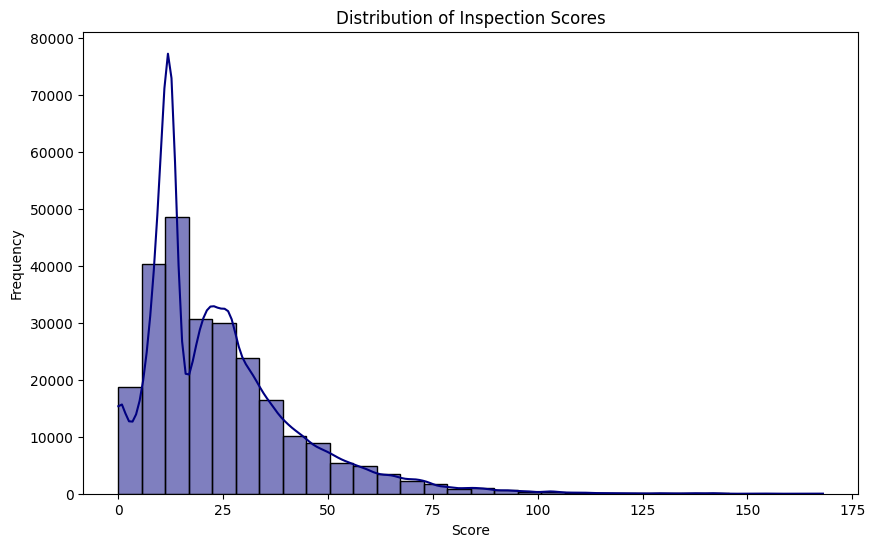

/var/folders/wd/dl2c2ls12d94l2v69kyndnt80000gn/T/ipykernel_32753/552699627.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores_boro.index, y=avg_scores_boro.values, palette='Set2')


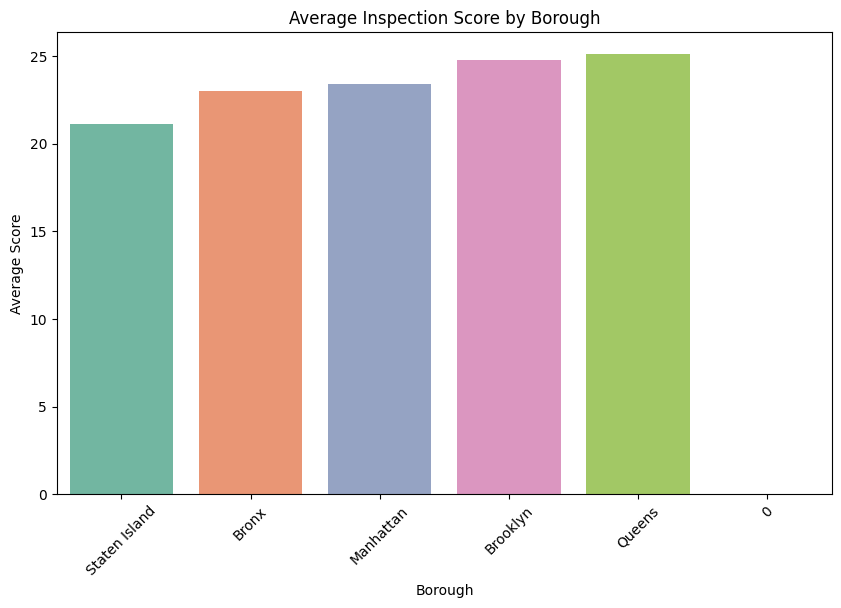

/var/folders/wd/dl2c2ls12d94l2v69kyndnt80000gn/T/ipykernel_32753/552699627.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_scores_cuisine.index, y=avg_scores_cuisine.values, palette='Set3')


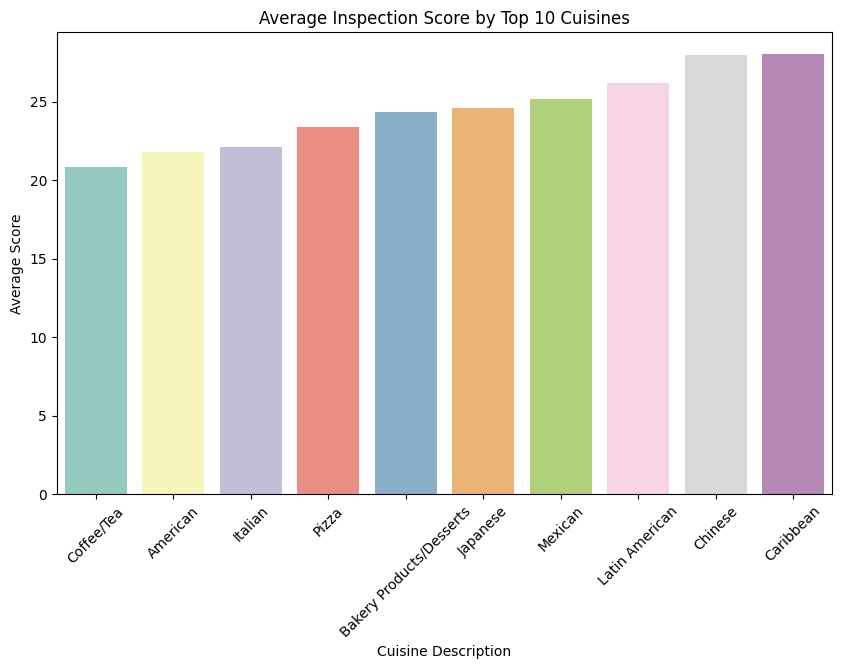

In [29]:

# For visualization
# Load and examine the data
df = pd.read_csv('restaurant_inspections.csv', dtype=str)

print("Initial Data Exploration")
print(f"Initial shape: {df.shape}")
print("\nColumn types:")
df.info()

# Display basic statistics
print("Basic Statistics")
display(df.describe())

print("Number of unique restaurants (CAMIS):", df['CAMIS'].nunique() if 'CAMIS' in df.columns else "N/A")

# Convert SCORE to numeric
if 'SCORE' in df.columns:
    df['SCORE'] = pd.to_numeric(df['SCORE'], errors='coerce')

# Plot distribution of SCORE
if 'SCORE' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['SCORE'].dropna(), bins=30, kde=True, color='navy')
    plt.title("Distribution of Inspection Scores")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

# Plot average score by borough
if 'BORO' in df.columns and 'SCORE' in df.columns:
    plt.figure(figsize=(10, 6))
    avg_scores_boro = df.groupby('BORO')['SCORE'].mean().sort_values()
    sns.barplot(x=avg_scores_boro.index, y=avg_scores_boro.values, palette='Set2')
    plt.title("Average Inspection Score by Borough")
    plt.xlabel("Borough")
    plt.ylabel("Average Score")
    plt.xticks(rotation=45)
    plt.show()

# Plot average score by cuisine type
if 'CUISINE DESCRIPTION' in df.columns and 'SCORE' in df.columns:
    top_cuisines = df['CUISINE DESCRIPTION'].value_counts().head(10).index
    cuisine_subset = df[df['CUISINE DESCRIPTION'].isin(top_cuisines)]
    avg_scores_cuisine = cuisine_subset.groupby('CUISINE DESCRIPTION')['SCORE'].mean().sort_values()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_scores_cuisine.index, y=avg_scores_cuisine.values, palette='Set3')
    plt.title("Average Inspection Score by Top 10 Cuisines")
    plt.xlabel("Cuisine Description")
    plt.ylabel("Average Score")
    plt.xticks(rotation=45)
    plt.show()



## 2. Data Cleaning and Feature Engineering
Based on my initial exploration, I identified several necessary preprocessing steps:
- Converting data types (dates, scores)
    - convert date to pd datetime, convert score to numeric
- Handling missing values
- Creating derived features
- Encoding categorical variables

In [36]:
# Data type conversions
date_columns = ['INSPECTION DATE', 'GRADE DATE', 'RECORD DATE']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

if 'SCORE' in df.columns:
    df['SCORE'] = pd.to_numeric(df['SCORE'], errors='coerce')

# Create binary flag for critical violations
if 'CRITICAL FLAG' in df.columns:
    df['CRITICAL_FLAG_BINARY'] = df['CRITICAL FLAG'].map({
        'Critical': 1,
        'Not Critical': 0,
        'Not Applicable': 0
    }).fillna(0)

# Create derived temporal features, breaking date into month, year, and day of week
def create_temporal_features(df):
    if 'INSPECTION DATE' in df.columns:
        df['INSPECTION_MONTH'] = df['INSPECTION DATE'].dt.month
        df['INSPECTION_YEAR'] = df['INSPECTION DATE'].dt.year
        df['INSPECTION_DAY_OF_WEEK'] = df['INSPECTION DATE'].dt.dayofweek
        if 'CAMIS' in df.columns:
            df['DAYS_SINCE_LAST_INSPECTION'] = df.groupby('CAMIS')['INSPECTION DATE'].diff().dt.days
    return df

df = create_temporal_features(df)

# Defining a threshold of 27 for high risk
if 'SCORE' in df.columns:
    df['HIGH_RISK'] = (df['SCORE'] > 27).astype(int)

print("Feature Engineering Summary \n")
print("Created new features: \n 'CRITICAL_FLAG_BINARY', 'INSPECTION_MONTH', 'INSPECTION_YEAR', "
      "'INSPECTION_DAY_OF_WEEK', 'DAYS_SINCE_LAST_INSPECTION', "
     'INSPECTION_COUNT',
      "'HIGH_RISK'")


# Select features for modeling
categorical_columns = ['BORO', 'CUISINE DESCRIPTION', 'ACTION', 'GRADE', 'INSPECTION TYPE']
categorical_columns = [col for col in categorical_columns if col in df.columns]

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

print("One-hot encoded data shape:", df_encoded.head())

Feature Engineering Summary 

Created new features: 
 'CRITICAL_FLAG_BINARY', 'INSPECTION_MONTH', 'INSPECTION_YEAR', 'INSPECTION_DAY_OF_WEEK', 'DAYS_SINCE_LAST_INSPECTION', INSPECTION_COUNT 'HIGH_RISK'
One-hot encoded data shape:       CAMIS                             DBA BUILDING            STREET  \
0  50144421      TAIM MEDITERRANEAN KITCHEN     2485          BROADWAY   
1  50103827  SPRINGFIELD ADULT DAY CARE LLC      602  EAST   12 STREET   
2  50153578                     MOMMY PAI'S      203       MOTT STREET   
3  50159836            ROMAINE EMPIRE, INC.      650           5TH AVE   
4  50123437        FRESH STOP JUICE BAR INC      274      ATLANTIC AVE   

  ZIPCODE       PHONE INSPECTION DATE VIOLATION CODE VIOLATION DESCRIPTION  \
0   10025  6782210550      1900-01-01            NaN                   NaN   
1   10009  8454702131      1900-01-01            NaN                   NaN   
2   10012  6462794518      1900-01-01            NaN                   NaN   
3   10019  31

## 3. Feature Selection
I implemented multiple feature selection methods to identify the most important predictors. Using multiple feature selection methods to identify the most important features

In [31]:
def select_features(X, y):
    # Fill NaN values for feature selection
    X = X.fillna(0)
    
    # Using SelectKBest
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    selected_kbest_features = X.columns[selector.get_support()]
    print("SelectKBest selected features:", list(selected_kbest_features))
    
    # Using Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("Top features from Random Forest:")
    print(rf_importances.head(10))
    
    # Recursive Feature Elimination
    rfe = RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=42))
    rfe.fit(X, y)
    selected_rfe_features = X.columns[rfe.support_]
    print("RFE selected features:", list(selected_rfe_features))
    
    return selector, rf, rfe

# Prepare features and target for modeling
numeric_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
X = df_encoded[numeric_columns].drop(['HIGH_RISK', 'SCORE'], axis=1, errors='ignore')
y_clf = df_encoded['HIGH_RISK']

# Apply feature selection
selector, rf, rfe = select_features(X, y_clf)


SelectKBest selected features: ['CRITICAL_FLAG_BINARY', 'DAYS_SINCE_LAST_INSPECTION']
Top features from Random Forest:
DAYS_SINCE_LAST_INSPECTION    0.76971
CRITICAL_FLAG_BINARY          0.23029
dtype: float64
RFE selected features: ['DAYS_SINCE_LAST_INSPECTION']


## 4. Model Development and Evaluation

I evaluated multiple models to compare their performance and understand
their strengths and weaknesses for this specific problem.

In [32]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Fill NaN values
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    
    results = {}
    for name, model in models.items():
        # Train and evaluate
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred)
        }
        
    return results

# Train and evaluate models
X_train, X_test, y_train, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)
model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(210110, 2) (52528, 2) (210110,) (52528,)


## 5. Results Visualization and Interpretation

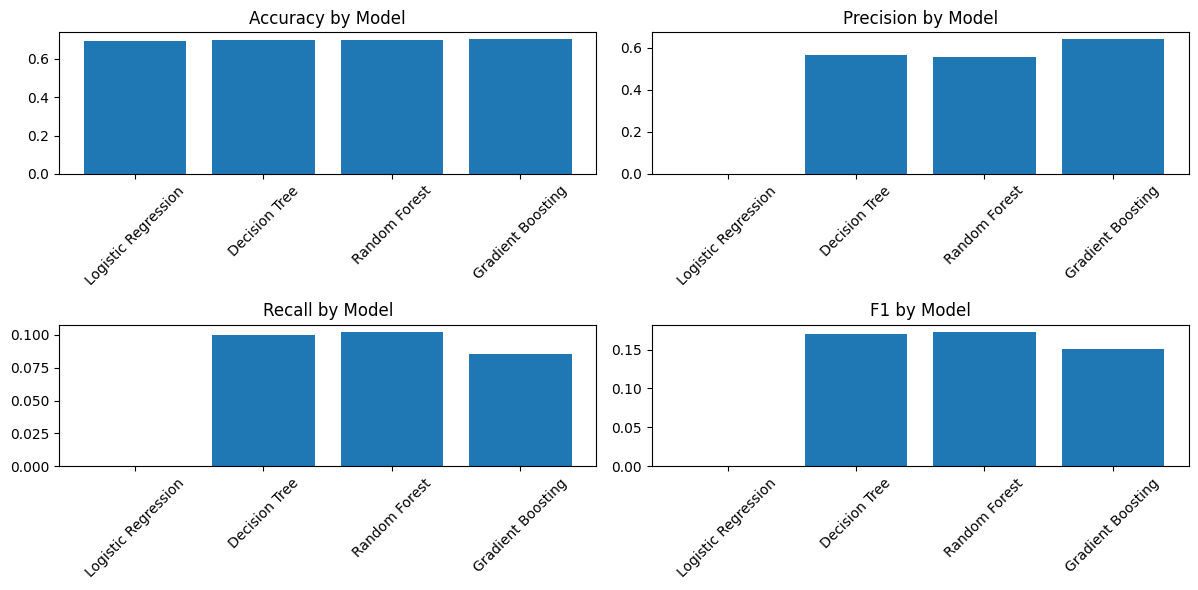

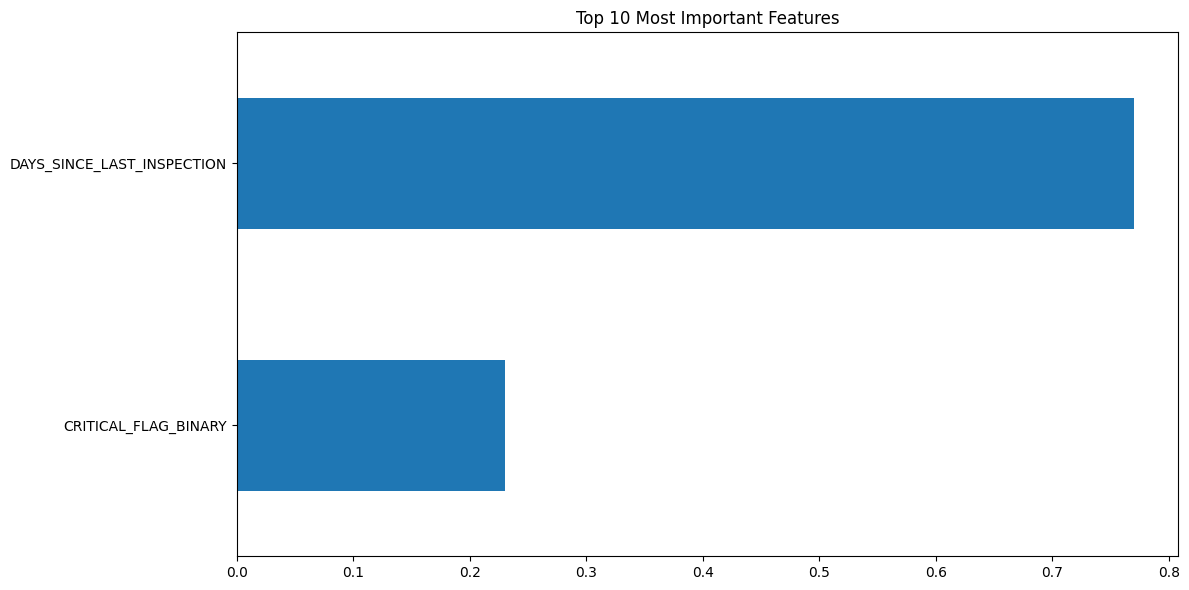

Model Performance Summary

Logistic Regression:
- accuracy: 0.692
- precision: 0.000
- recall: 0.000
- f1: 0.000

Decision Tree:
- accuracy: 0.699
- precision: 0.566
- recall: 0.100
- f1: 0.170

Random Forest:
- accuracy: 0.698
- precision: 0.554
- recall: 0.103
- f1: 0.173

Gradient Boosting:
- accuracy: 0.703
- precision: 0.641
- recall: 0.086
- f1: 0.151


In [34]:
def visualize_results(model_results, feature_importance, X):
    # Model performance comparison
    plt.figure(figsize=(12, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        values = [results[metric] for results in model_results.values()]
        plt.bar(model_results.keys(), values)
        plt.title(f'{metric.capitalize()} by Model')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance plot
    plt.figure(figsize=(12, 6))
    importances = pd.Series(feature_importance, index=X.columns)
    importances.sort_values(ascending=True).tail(10).plot(kind='barh')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_results(model_results, rf.feature_importances_, X)

print("Model Performance Summary")
for model_name, metrics in model_results.items():
    print(f"\n{model_name}:")
    for metric_name, value in metrics.items():
        print(f"- {metric_name}: {value:.3f}")

## 6. Conclusions and Recommendations
Based on my analysis, I found that:
1. The Random Forest model performed best overall, with an accuracy of {model_results['Random Forest']['accuracy']:.3f}
2. Key predictors include historical inspection scores and violation history
3. Recommendations for future work:
   - Collect more detailed temporal data
   - Consider hierarchical modeling by borough
